In [1]:
#https://www.depends-on-the-definition.com/guide-sequence-tagging-neural-networks-python/
#https://www.depends-on-the-definition.com/sequence-tagging-lstm-crf/
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

/Users/h/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


data from kaggle https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus

In [2]:
def read_data(path_read):
    df = pd.read_csv(path_read, encoding="latin1")    
    return df

path_read= "data/ner_dataset.csv"
df= read_data(path_read)
df.tail()

#df= df[:5000]

,Sentence #,Word,POS,Tag
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O
1048574,NaN,attack,NN,O


In [3]:
def fix_missing_value(df):
    df = df.fillna(method="ffill")
    return df
df= fix_missing_value(df)
df.tail()

,Sentence #,Word,POS,Tag
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [4]:
def get_words_tags(df):
    words = list(set(df["Word"].values))
    words.append("ENDPAD")
    n_words = len(words)
    print("total words number:", n_words)
    
    tags = list(set(df["Tag"].values))
    n_tags = len(tags)
    print("total tags number:", n_tags)
    
    return words, tags, n_words, n_tags

words, tags, n_words, n_tags= get_words_tags(df)

total words number: 35179
total tags number: 17


In [5]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(df)   
sentences = getter.sentences

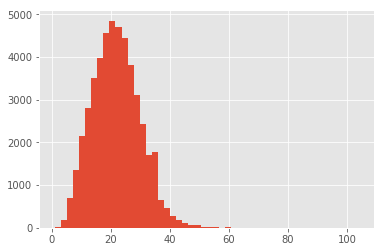

In [6]:
def plot_sent_lens(sentences):
    plt.style.use("ggplot")
    plt.hist([len(s) for s in sentences], bins=50)
    plt.show()
plot_sent_lens(sentences)

In [7]:
def encoding(max_len, sentences, words, tags):
    word2idx = {w: i + 1 for i, w in enumerate(words)}
    tag2idx = {t: i for i, t in enumerate(tags)}
    X = [[word2idx[w[0]] for w in s] for s in sentences]
    X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)

    y = [[tag2idx[w[2]] for w in s] for s in sentences]
    y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
    y = [to_categorical(i, num_classes=n_tags) for i in y]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    return X_train, X_test, y_train, y_test, word2idx, tag2idx

max_len = 75
X_train, X_test, y_train, y_test, word2idx, tag2idx= encoding(max_len, sentences, words, tags)

In [8]:
def model_LSTM(max_len, n_words, n_tags):
    input = Input(shape=(max_len,))
    model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
    model = Dropout(0.1)(model)
    model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
    out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer
    model = Model(input, out)
    model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

    model.summary()
    return model

In [9]:
def model_LSTM_CRF(max_len, n_words, n_tags):
    input = Input(shape=(max_len,))
    model = Embedding(input_dim=n_words + 1, output_dim=20,
                      input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
    model = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.1))(model)  # variational biLSTM
    model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
    crf = CRF(n_tags)  # CRF layer
    out = crf(model)  # output
    model = Model(input, out)
    model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
    model.summary()
    return model

In [10]:
model= model_LSTM_CRF(max_len, n_words, n_tags)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            703600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 17)            1190      
Total params: 738,240
Trainable params: 738,240
Non-trainable params: 0
_________________________________________________________________


In [11]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    plt.style.use("ggplot")
    plt.figure(figsize=(12,12))
    plt.plot(hist["acc"])
    plt.plot(hist["val_acc"])
    plt.show()

Train on 38846 samples, validate on 4317 samples
Epoch 1/3
38846/38846 [==============================] - 240s 6ms/step - loss: 0.0335 - acc: 0.9877 - val_loss: 0.0283 - val_acc: 0.9891
Epoch 2/3
38846/38846 [==============================] - 228s 6ms/step - loss: 0.0245 - acc: 0.9902 - val_loss: 0.0244 - val_acc: 0.9901
Epoch 3/3
38846/38846 [==============================] - 241s 6ms/step - loss: 0.0211 - acc: 0.9912 - val_loss: 0.0226 - val_acc: 0.9906


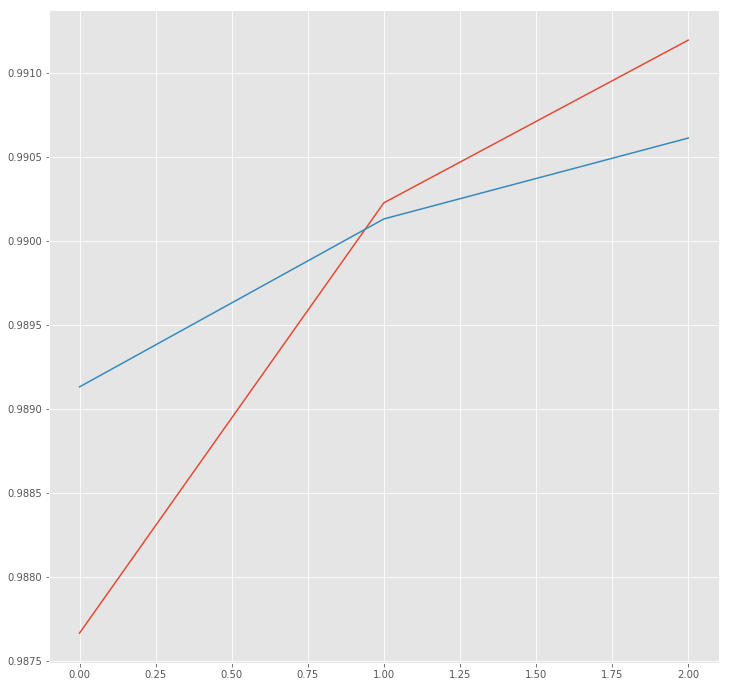

4796/4796 [==============================] - 7s 1ms/step


In [16]:
def train_model(batch_size= 32, epochs=3, X_train= X_train, y_train= y_train, X_test= X_test):
    history = model.fit(X_train, np.array(y_train), batch_size= batch_size, epochs= epochs,
                        validation_split=0.1, verbose=1)
    
    plot_history(history)
    
    test_pred = model.predict(X_test, verbose=1)
    return test_pred
    
batch_size=32
epochs=3
test_pred= train_model(batch_size, epochs)

In [17]:
def pred2label(pred):
    idx2tag = {i: w for w, i in tag2idx.items()}
    
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out

pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

In [18]:
def evaluation(test_labels, pred_labels):
    print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))  
    print(classification_report(test_labels, pred_labels))  

evaluation(test_labels, pred_labels)

F1-score: 82.8%
             precision    recall  f1-score   support

        gpe       0.97      0.92      0.94      1560
        tim       0.89      0.84      0.86      2049
        per       0.78      0.77      0.77      1638
        geo       0.83      0.90      0.86      3660
        org       0.78      0.62      0.69      1978
        eve       0.00      0.00      0.00        29
        art       0.00      0.00      0.00        50
        nat       0.00      0.00      0.00        15

avg / total       0.83      0.81      0.82     10979



In [19]:
def test_case(i, model, X_test):
    p = model.predict(np.array([X_test[i]]))
    p = np.argmax(p, axis=-1)
    true = np.argmax(y_test[i], -1)
    print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
    print(30 * "=")
    for w, t, pred in zip(X_test[i], true, p[0]):
        if w != 0:
            print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

i = 1927
test_case(i, model, X_test)

Word           ||True ||Pred
The            : O     O
group          : O     O
now            : O     O
has            : O     O
57             : O     O
members        : O     O
and            : O     O
is             : O     O
looking        : O     O
for            : O     O
new            : O     O
recruits       : O     O
outside        : O     O
the            : O     O
United         : B-geo B-geo
States         : I-geo I-geo
.              : O     O
cities         : O     O
cities         : O     O
cities         : O     O
cities         : O     O
cities         : O     O
cities         : O     O
cities         : O     O
cities         : O     O
cities         : O     O
cities         : O     O
cities         : O     O
cities         : O     O
cities         : O     O
cities         : O     O
cities         : O     O
cities         : O     O
cities         : O     O
cities         : O     O
cities         : O     O
cities         : O     O
cities         : O     O
cities       